In [1]:
# --- 0) Imports + API key + client (run this cell first) ---
import os
from getpass import getpass

import pandas as pd
import matplotlib.pyplot as plt

from openai import OpenAI
from pydantic import BaseModel

# Enter key once per kernel session
os.environ["OPENAI_API_KEY"] = getpass("OpenAI API key: ")
client = OpenAI()

OpenAI API key: ········


In [3]:
# --- 1) Load data + keep only the columns we care about ---
path = "/Users/angusmclean/Downloads/Boeing_clean_clustered_full.csv"
df = pd.read_csv(path)

# Parse dates (UTC)
df["Date"] = pd.to_datetime(df["Date"], utc=True, errors="coerce")

# Clean key fields
df["gx_cluster"] = df["gx_cluster"].astype(str).str.strip()
df["Snippet"] = df["Snippet"].astype(str)

# Clean impressions (weights)
df["Impressions"] = pd.to_numeric(df["Impressions"], errors="coerce").fillna(0)

/var/folders/y5/8rly0f7n34s4b0dgj2d7k0gc0000gn/T/ipykernel_9776/3047218105.py:3: DtypeWarning: Columns (15,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [4]:
# --- 2) Sample 10 tweets per cluster (for labeling) ---
sampled_df = (
    df.dropna(subset=["gx_cluster", "Snippet"])
      .groupby("gx_cluster", group_keys=False)
      .apply(lambda x: x.sample(n=min(10, len(x)), random_state=42))
      .loc[:, ["gx_cluster", "Snippet"]]
)

cluster_samples = (
    sampled_df.groupby("gx_cluster")["Snippet"]
              .apply(lambda s: [str(x) for x in s.dropna().tolist()])
              .to_dict()
)

len(cluster_samples), list(cluster_samples.keys())[:3]

(69,
 ['$, billion, qatar, deal',
  '2030, fly on 100, sustainable, 50 airlines',
  '7.8 billion people, 747 cargo aircraft, 8,00 boeing 747 cargo, billion people'])

In [5]:
# --- 3) Ask OpenAI for human-readable labels (stored as gpt_label) ---
class ClusterLabel(BaseModel):
    gpt_label: str
    description: str
    keywords: list[str]

def label_one_cluster(cluster_key: str, snippets: list[str]) -> dict:
    prompt = (
        "You are labeling topic clusters of tweets.\n"
        "IMPORTANT RULES:\n"
        "- Do NOT include the word 'Boeing' in the label.\n"
        "- Assume the entire dataset is about Boeing.\n"
        "- Labels must be concise and human-readable (3–7 words).\n"
        "- Focus on events, themes, actors, or issues.\n"
        "- Only mention a company name if it is NOT Boeing (e.g., Airbus, SpaceX).\n\n"
        "Return:\n"
        "- gpt_label: short descriptive phrase\n"
        "- description: 1–2 sentences\n"
        "- keywords: 3–8 keywords\n\n"
        f"TF–IDF CLUSTER KEY (keep exact): {cluster_key}\n"
        "TWEET SNIPPETS:\n"
        + "\n".join([f"{i+1}. {snip}" for i, snip in enumerate(snippets)])
    )

    resp = client.responses.parse(
        model="gpt-4o-mini",
        input=prompt,
        text_format=ClusterLabel,
    )

    out = resp.output_parsed.model_dump()
    out["gx_cluster"] = cluster_key  # attach true key (never overwritten)
    return out

results = [label_one_cluster(k, snips) for k, snips in cluster_samples.items()]
labels_df = pd.DataFrame(results)

labels_df.head()

,gpt_label,description,keywords,gx_cluster
0,Qatar Military and Trade Deals,The tweets highlight various significant trade...,"[Qatar, trade, military, deals, Trump, jobs, d...","$, billion, qatar, deal"
1,Sustainable Aviation Fuel Initiatives,This cluster focuses on efforts by airlines an...,"[sustainable aviation fuels, biofuels, emissio...","2030, fly on 100, sustainable, 50 airlines"
2,Global Vaccine Distribution Challenge,The tweets highlight the logistical challenges...,"[vaccine distribution, global health, air carg...","7.8 billion people, 747 cargo aircraft, 8,00 b..."
3,737 Max Safety Concerns,Discussions around the safety of the 737 Max a...,"[737 Max, safety, FAA, aviation, crashes, regu...","737 max, max, faa, pilot"
4,Controversies Surrounding 9/11 Events,The tweets discuss the contested narratives an...,"[9/11, Pentagon, Flight 77, eyewitness account...","9/11, pentagon, flight 77, building"


In [6]:
# --- 4) Save labels + merge into df ---
labels_df.to_csv("boeing_cluster_labels.csv", index=False)

df = df.merge(labels_df[["gx_cluster", "gpt_label"]], on="gx_cluster", how="left")

df[["gx_cluster", "gpt_label"]].drop_duplicates().head(10)

,gx_cluster,gpt_label
0,"starliner, space, astronaut, launch",Spacecraft Launch and Challenges
1,"iran, military, video, israel",Military Air Operations in the Middle East
3,"emergency landing, landing, emergency, engine",Emergency Landings and Engine Issues
4,"$, billion, qatar, deal",Qatar Military and Trade Deals
5,"9/11, pentagon, flight 77, building",Controversies Surrounding 9/11 Events
6,"whistleblower, boeing whistleblower, barnett, ...",Whistleblower Allegations and Concerns
7,"seat, 11a, exit, row",Flight Safety and Seat Information
8,"seahawkscamp, seahawkscamp x boeing, gohawks, ...",Seahawks Camp Partnership
9,"indonesia, jakarta, sea, indonesian",Indonesian Airline Crashes
11,"india, turkish, air india, technic",India's Aviation Developments


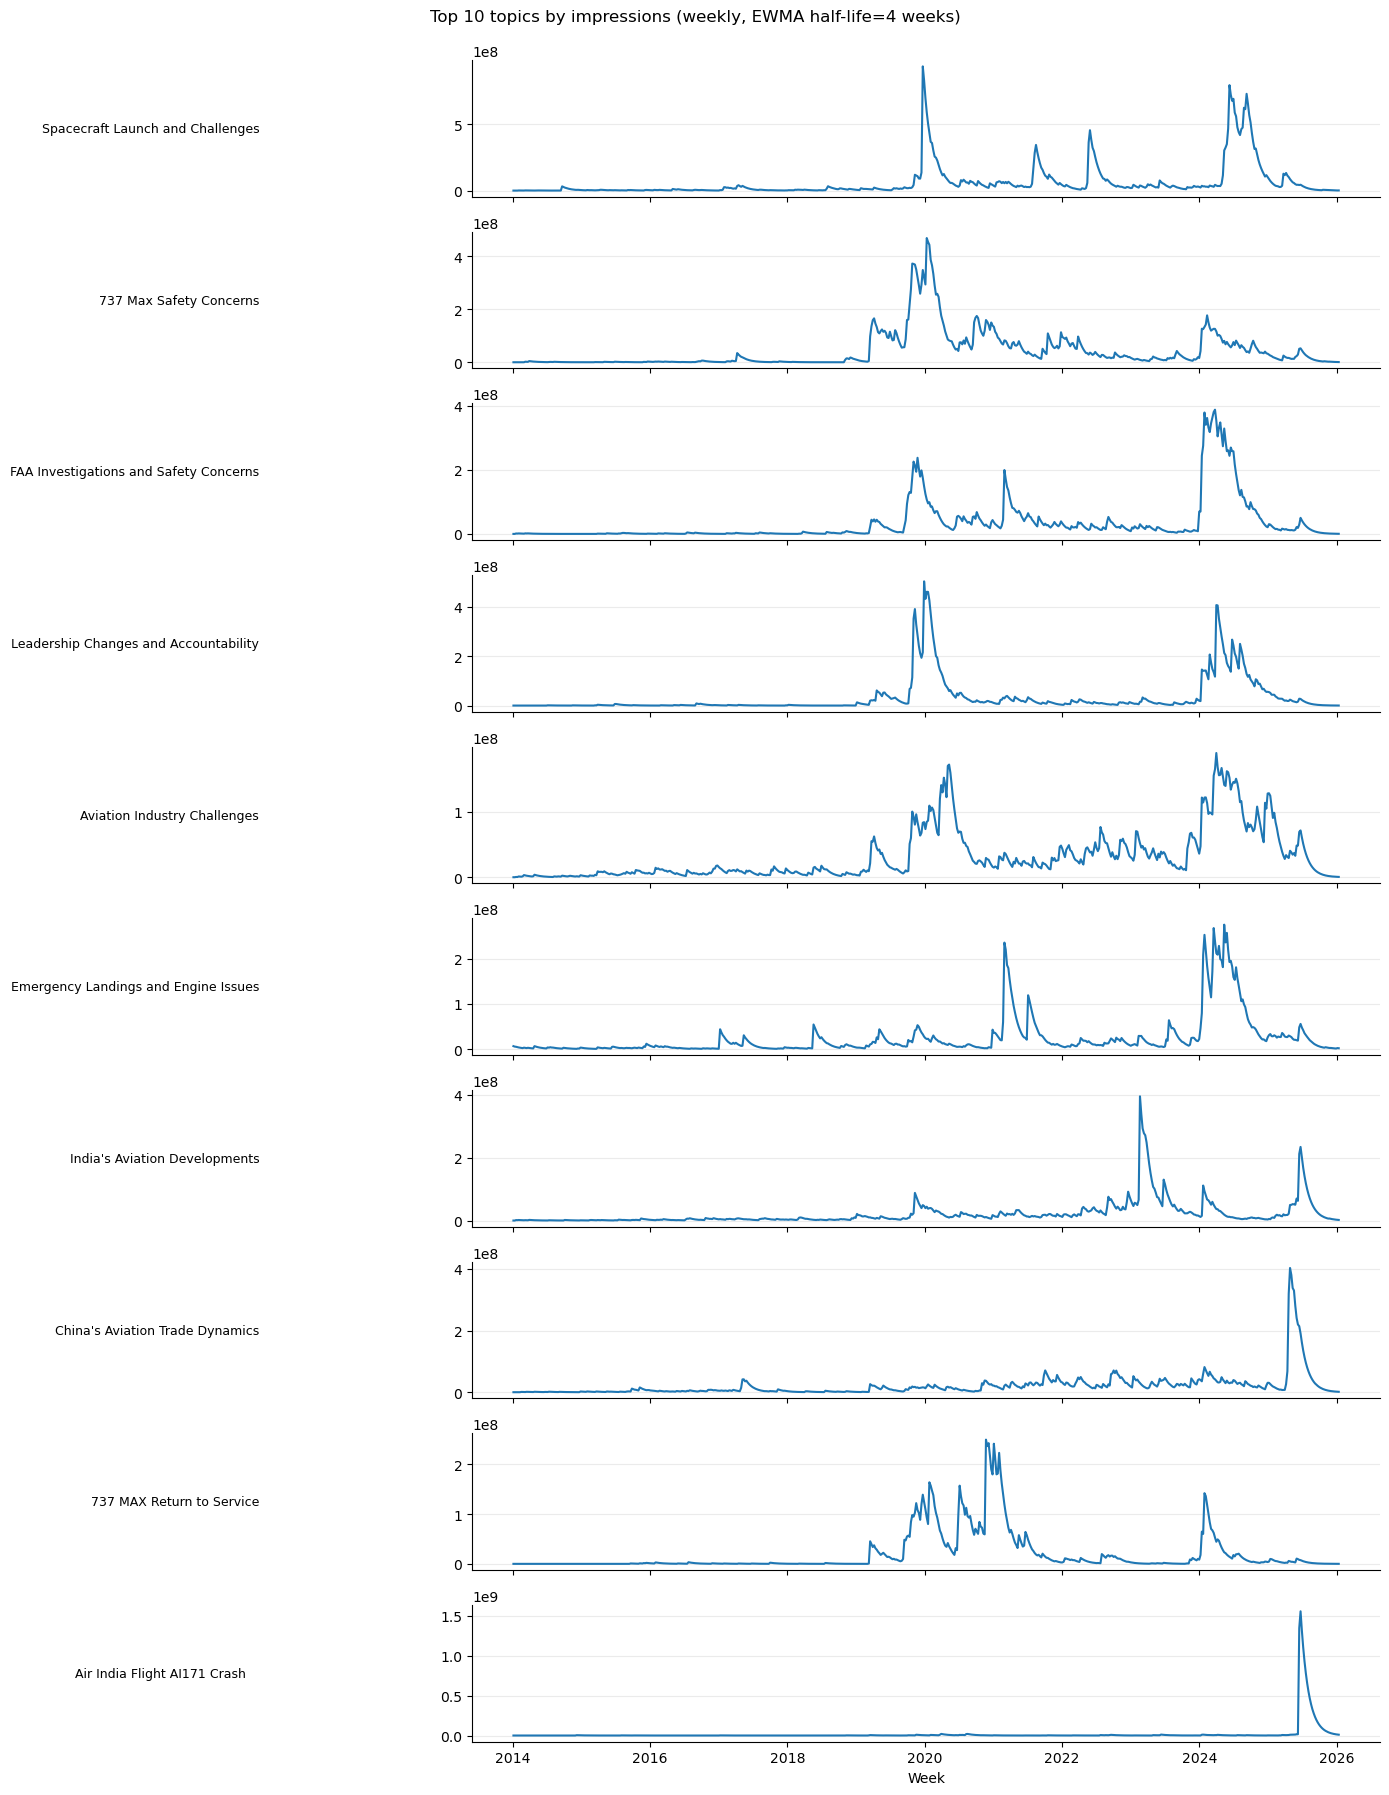

In [7]:
# --- 5) Plot: Top 10 clusters by impressions, as 10 horizontal lanes (weekly + decay) ---

freq = "W"             # weekly
half_life_weeks = 4    # decay/smoothing
top_n = 10
normalize_each = False  # True = scale each lane 0..1 for shape comparison

# Weekly impressions per TF–IDF cluster key
weekly = (
    df.dropna(subset=["Date", "gx_cluster"])
      .set_index("Date")
      .groupby("gx_cluster")
      .resample(freq)["Impressions"]
      .sum()
      .unstack("gx_cluster")
      .fillna(0)
      .sort_index()
)

# Pick top N by total impressions
top_clusters = weekly.sum().sort_values(ascending=False).head(top_n).index
weekly_top = weekly[top_clusters]

# EWMA decay
smoothed = weekly_top.ewm(halflife=half_life_weeks, adjust=False).mean()

# Map clusters to GPT labels for display
label_map = labels_df.set_index("gx_cluster")["gpt_label"].to_dict()

# Prepare data for plotting (optionally normalized)
plot_data = smoothed.copy()
if normalize_each:
    plot_data = plot_data / plot_data.max()

# Plot as lanes
n = len(top_clusters)
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(14, 1.8*n), sharex=True)

if n == 1:
    axes = [axes]

for ax, cluster_key in zip(axes, top_clusters):
    series = plot_data[cluster_key]
    ax.plot(series.index, series.values)

    pretty = label_map.get(cluster_key, cluster_key)
    ax.set_ylabel(pretty, rotation=0, ha="right", va="center", labelpad=140, fontsize=9)

    ax.grid(True, axis="y", alpha=0.25)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[-1].set_xlabel("Week")
title = f"Top {top_n} topics by impressions (weekly, EWMA half-life={half_life_weeks} weeks)"
if normalize_each:
    title += " — normalized per topic"
fig.suptitle(title, y=0.995)

plt.tight_layout()
plt.show()

# Re-Order By Event for Causality :

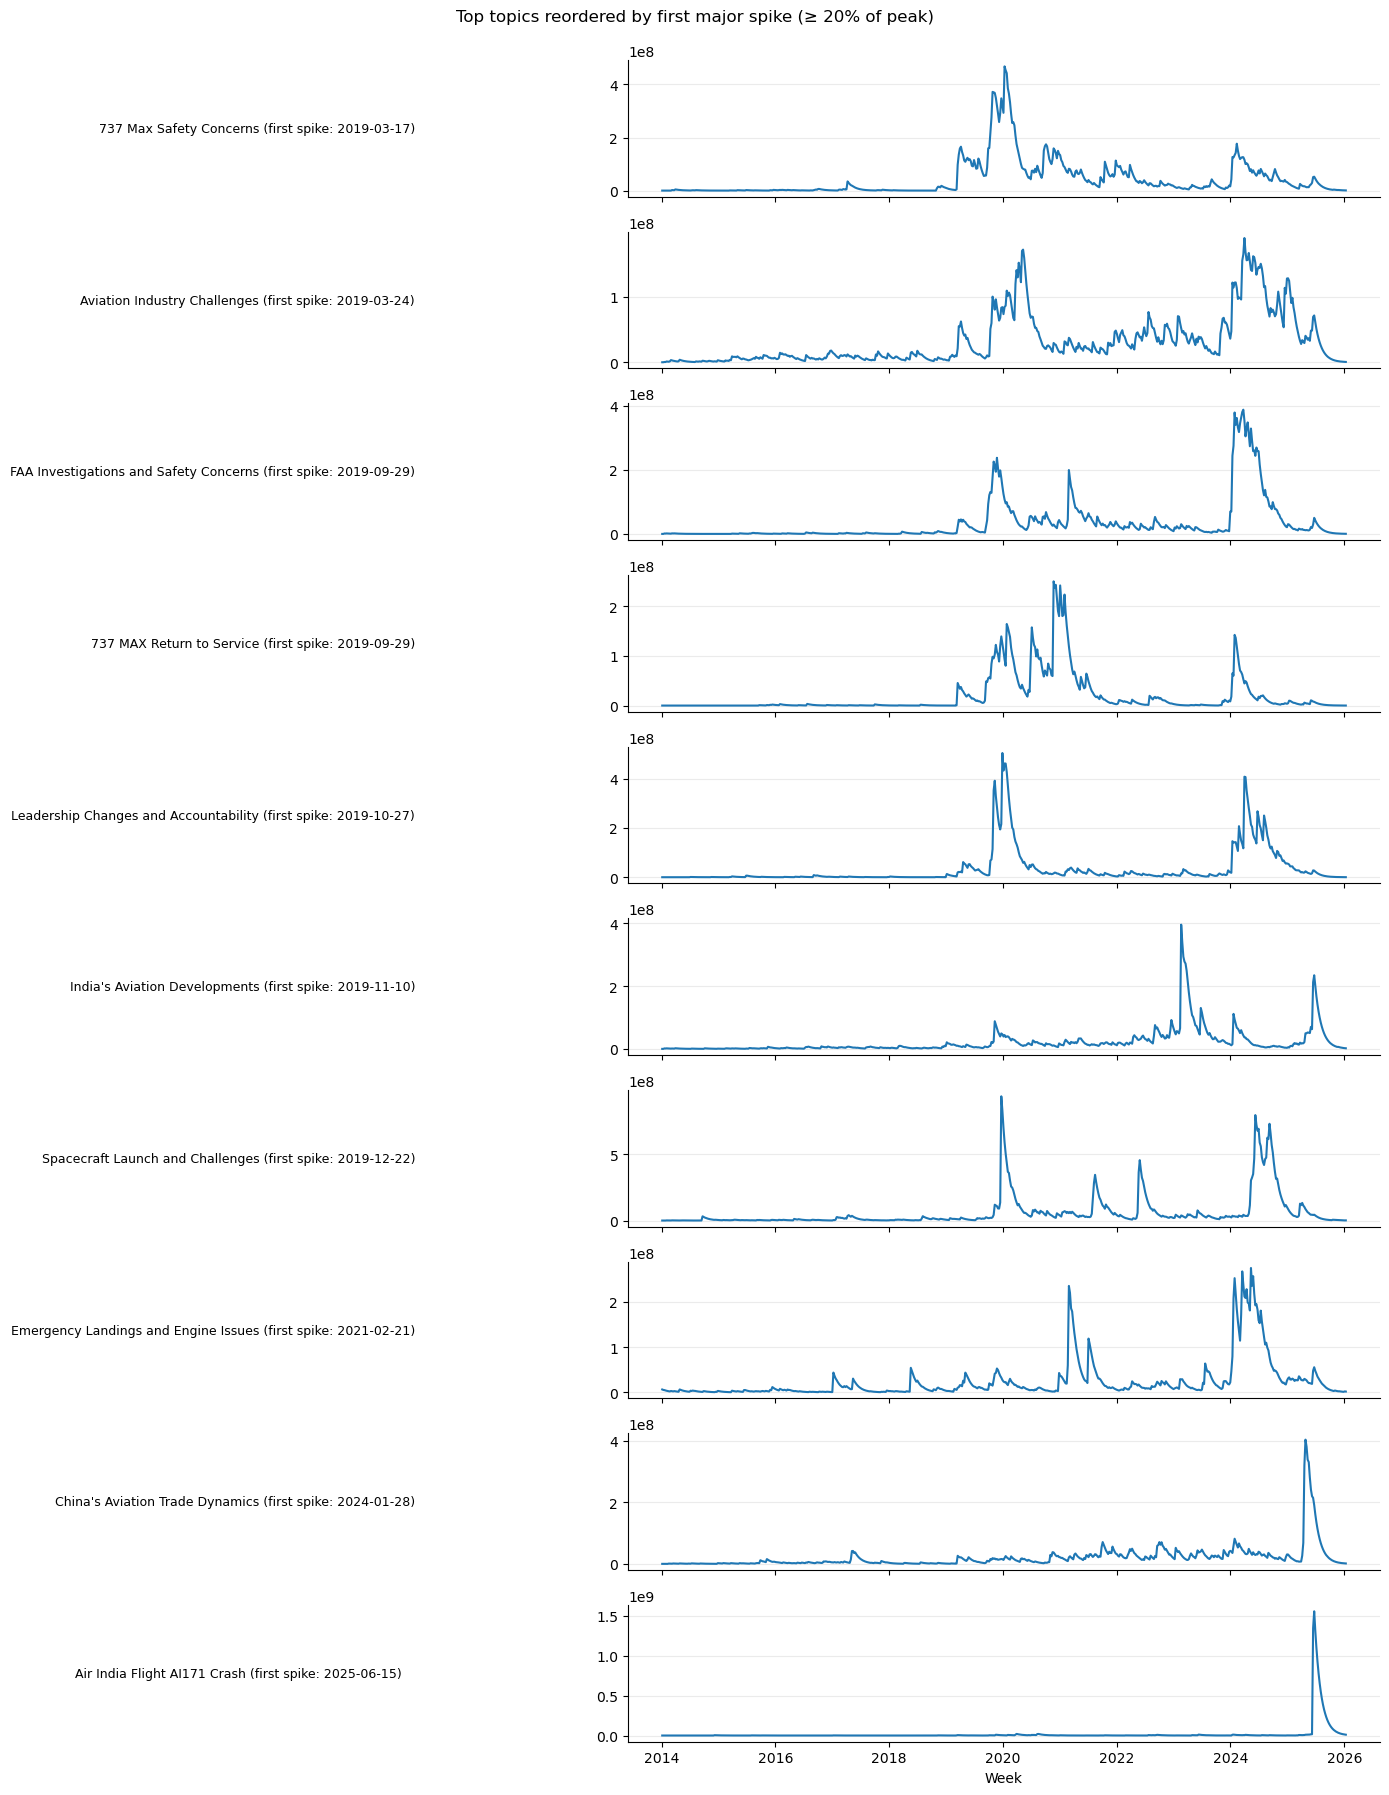

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# smoothed: your EWMA weekly impressions per cluster (columns are gx_cluster keys)
# labels_df: has gx_cluster -> gpt_label

event_threshold_frac = 0.2  # tweak (0.1, 0.2, 0.3)

label_map = labels_df.set_index("gx_cluster")["gpt_label"].to_dict()

# 1) Find first "major" spike date per topic (relative to its own peak)
event_dates = {}
for c in smoothed.columns:
    s = smoothed[c]
    m = s.max()
    if m <= 0:
        event_dates[c] = pd.NaT
        continue
    thresh = event_threshold_frac * m
    event_dates[c] = s[s >= thresh].index.min()

# 2) Order columns by first event date (NaT go last)
ordered = sorted(
    smoothed.columns,
    key=lambda c: (pd.isna(event_dates[c]), event_dates[c])
)

# 3) Plot in that order (same x-axis, just reordered lanes)
plot_data = smoothed[ordered]

n = plot_data.shape[1]
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(14, 1.8*n), sharex=True)
if n == 1:
    axes = [axes]

for ax, c in zip(axes, ordered):
    ax.plot(plot_data.index, plot_data[c])

    # label includes event date to make the ordering obvious
    pretty = label_map.get(c, c)
    t0 = event_dates[c]
    suffix = "" if pd.isna(t0) else f" (first spike: {t0.date()})"

    ax.set_ylabel(pretty + suffix, rotation=0, ha="right", va="center", labelpad=140, fontsize=9)
    ax.grid(True, axis="y", alpha=0.25)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[-1].set_xlabel("Week")
fig.suptitle(f"Top topics reordered by first major spike (≥ {int(event_threshold_frac*100)}% of peak)", y=0.995)

plt.tight_layout()
plt.show()


In [9]:
# --- Load Boeing stock CSV ---
stock_path = "/Users/angusmclean/Downloads/Boeing_Nasdaq_Data.csv"
stock_df = pd.read_csv(stock_path)

# Rename for sanity
stock_df = stock_df.rename(columns={
    "Date": "Date",
    "Close/Last": "Close"
})

# Parse date
stock_df["Date"] = pd.to_datetime(stock_df["Date"], format="%m/%d/%Y", errors="coerce")

# Remove $ and convert to numeric
for col in ["Close", "Open", "High", "Low"]:
    stock_df[col] = (
        stock_df[col]
        .astype(str)
        .str.replace("$", "", regex=False)
        .astype(float)
    )

# Volume to numeric (already is, but safe)
stock_df["Volume"] = pd.to_numeric(stock_df["Volume"], errors="coerce")

# Sort chronologically (VERY important)
stock_df = stock_df.sort_values("Date")

stock_df.head()

,Date,Close,Volume,Open,High,Low
2514,2016-01-25,124.01,4548505,124.60,125.24,123.40
2513,2016-01-26,128.01,5430877,124.98,128.15,124.50
2512,2016-01-27,116.58,27930890,119.90,120.11,115.02
2511,2016-01-28,118.01,10707400,117.10,118.03,115.06
2510,2016-01-29,120.13,9194165,118.14,120.18,118.02


In [10]:
# Weekly close (last trading day of week)
stock_weekly = (
    stock_df
    .set_index("Date")["Close"]
    .resample("W")
    .last()
    .ffill()
)

# Apply same EWMA smoothing
half_life_weeks = 4  # must match topic plot
stock_smoothed = stock_weekly.ewm(halflife=half_life_weeks, adjust=False).mean()

In [11]:
# stock_smoothed = stock_smoothed / stock_smoothed.iloc[0] - 1

In [12]:
# Remove old inferred market topic
remove_label = "Market Impact and Dow Performance"
inverse_label_map = {v: k for k, v in label_map.items()}
market_cluster_key = inverse_label_map.get(remove_label)

if market_cluster_key in smoothed.columns:
    smoothed = smoothed.drop(columns=[market_cluster_key])

# --- FIX: align index timezones for reindexing ---
# smoothed index is likely tz-aware (UTC) because df["Date"] was parsed utc=True
# stock_smoothed index is tz-naive, so reindex won't match unless we align them
if getattr(smoothed.index, "tz", None) is not None:
    smoothed.index = smoothed.index.tz_convert(None)

# Insert real stock series
smoothed["Boeing stock price (real)"] = (
    stock_smoothed
    .reindex(smoothed.index)
    .ffill()
)

In [13]:
smoothed["Boeing stock price (real)"].isna().mean()

0.17197452229299362

In [14]:
print("Topics:", smoothed.index.min(), "→", smoothed.index.max())
print("Stock :", stock_smoothed.index.min(), "→", stock_smoothed.index.max())


Topics: 2014-01-05 00:00:00 → 2026-01-11 00:00:00
Stock : 2016-01-31 00:00:00 → 2026-01-25 00:00:00


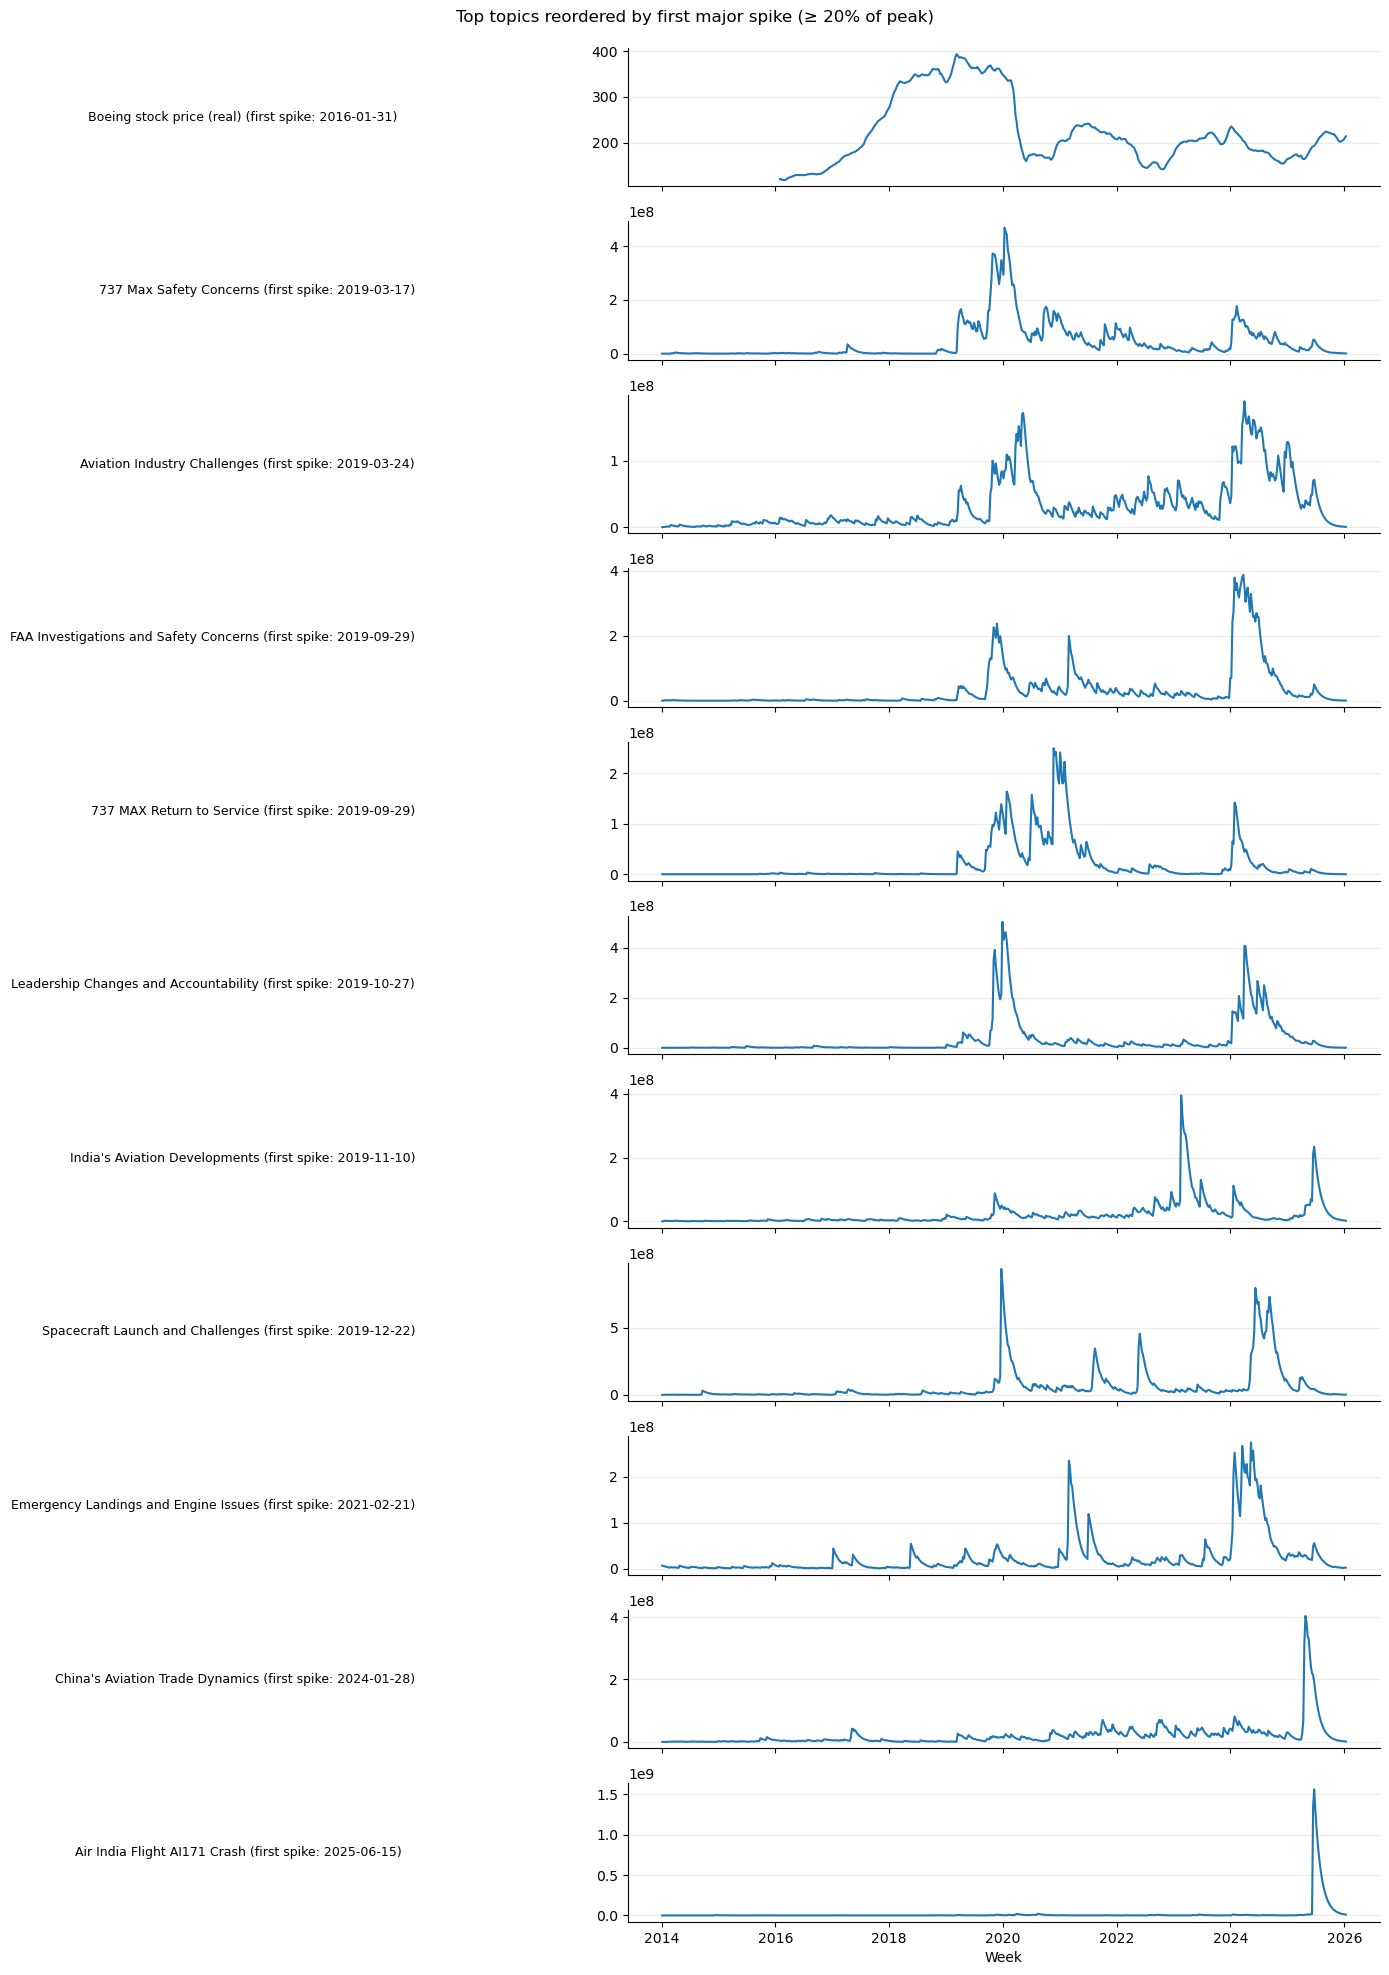

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# smoothed: your EWMA weekly impressions per cluster (columns are gx_cluster keys)
# labels_df: has gx_cluster -> gpt_label

event_threshold_frac = 0.2  # tweak (0.1, 0.2, 0.3)

label_map = labels_df.set_index("gx_cluster")["gpt_label"].to_dict()

# 1) Find first "major" spike date per topic (relative to its own peak)
event_dates = {}
for c in smoothed.columns:
    s = smoothed[c]
    m = s.max()
    if m <= 0:
        event_dates[c] = pd.NaT
        continue
    thresh = event_threshold_frac * m
    event_dates[c] = s[s >= thresh].index.min()

# 2) Order columns by first event date (NaT go last)
ordered = sorted(
    smoothed.columns,
    key=lambda c: (pd.isna(event_dates[c]), event_dates[c])
)

# 3) Plot in that order (same x-axis, just reordered lanes)
plot_data = smoothed[ordered]

n = plot_data.shape[1]
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(14, 1.8*n), sharex=True)
if n == 1:
    axes = [axes]

for ax, c in zip(axes, ordered):
    ax.plot(plot_data.index, plot_data[c])

    # label includes event date to make the ordering obvious
    pretty = label_map.get(c, c)
    t0 = event_dates[c]
    suffix = "" if pd.isna(t0) else f" (first spike: {t0.date()})"

    ax.set_ylabel(pretty + suffix, rotation=0, ha="right", va="center", labelpad=140, fontsize=9)
    ax.grid(True, axis="y", alpha=0.25)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[-1].set_xlabel("Week")
fig.suptitle(f"Top topics reordered by first major spike (≥ {int(event_threshold_frac*100)}% of peak)", y=0.995)

plt.tight_layout()
plt.show()

In [41]:
df.shape

(6100, 89)